In [ ]:
import os
import sys

import numpy as np
import torch

src_path = os.path.abspath(os.path.join("src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(sys.path)

['/nethome/abhalerao9/TIMESERIESMODELING/TSFMProject/src', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python311.zip', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/lib-dynload', '', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages']


In [ ]:
from samay.dataset import ChronosDataset
from samay.model import ChronosModel
from samay.visualization import ForecastVisualization

/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_dataset = ChronosDataset(
    name="ett",
    mode="train",
    path="/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv",
    datetime_col="date",
    freq="h",
    context_len=128,
    horizon_len=64,
)
test_dataset = ChronosDataset(
    name="ett",
    mode="test",
    path="/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv",
    datetime_col="date",
    freq="h",
    context_len=128,
    horizon_len=64,
)
# train_dataset = ChronosDataset(name="ett", mode="train", path='/nethome/abhalerao9/TIMESERIESMODELING/TSFMProject/data/dataset/timesfm_covid_pivot.csv', datetime_col='ds', freq='D', context_len=64, horizon_len=16)
# test_dataset = ChronosDataset(name="ett", mode="test", path='/nethome/abhalerao9/TIMESERIESMODELING/TSFMProject/data/dataset/timesfm_covid_pivot.csv', datetime_col='ds', freq='D', context_len=64, horizon_len=16)
print(len(test_dataset.dataset))
# print(test_dataset.dataset.shape)


52


In [6]:
repo = "amazon/chronos-t5-small"
ch = ChronosModel(config=None, repo=repo)
ch.load_model()


In [7]:
print(ch.model.model.device)

cuda:0


In [ ]:
eval_results, trues, preds, histories = ch.evaluate(
    test_dataset, batch_size=8, metrics=["MSE", "MASE"]
)
print(eval_results)
# visualization = ForecastVisualization(trues, preds[:,:,1,:], histories)
# visualization.plot()

{'MSE': 0.6350336, 'MASE': 1.730669}


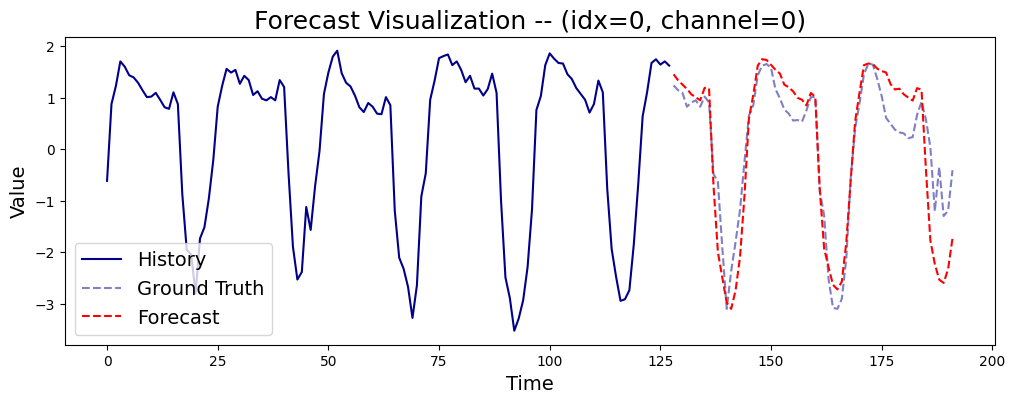

In [8]:
visualization = ForecastVisualization(trues, preds, histories)
visualization.plot(channel_idx=0, time_idx=0)

In [ ]:
print(trues.shape)
print(preds.shape)
print(histories.shape)


(52, 7, 64)
(52, 7, 64)
(52, 7, 128)


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [8]:
ch.finetune(train_dataset)


The speedups for torchdynamo mostly come wih GPU Ampere or higher and which is not detected here.
max_steps is given, it will override any value given in num_train_epochs
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
5,4.672300
10,4.600300
15,4.531500
20,4.542900
25,4.486700
30,4.480400
35,4.460000
40,4.450800
45,4.438400
50,4.429300


/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [9]:
latest_run_dir = ch.get_latest_run_dir()
model_dir = os.path.join(latest_run_dir, "checkpoint-final")
model_type = "seq2seq"
model = ch.load_model(model_dir, model_type)

INFO:results_logger:Model loaded from /nethome/abhalerao9/TIMESERIESMODELING/TSFMProject/src/./tsfmproject/models/chronosforecasting/output/finetuning/run-8/checkpoint-final


In [ ]:
eval_results, trues, preds, histories = ch.evaluate(
    test_dataset, batch_size=8, metrics=["MSE", "MASE"]
)
print(eval_results)

{'MSE': 0.5772213, 'MASE': 1.6072242}


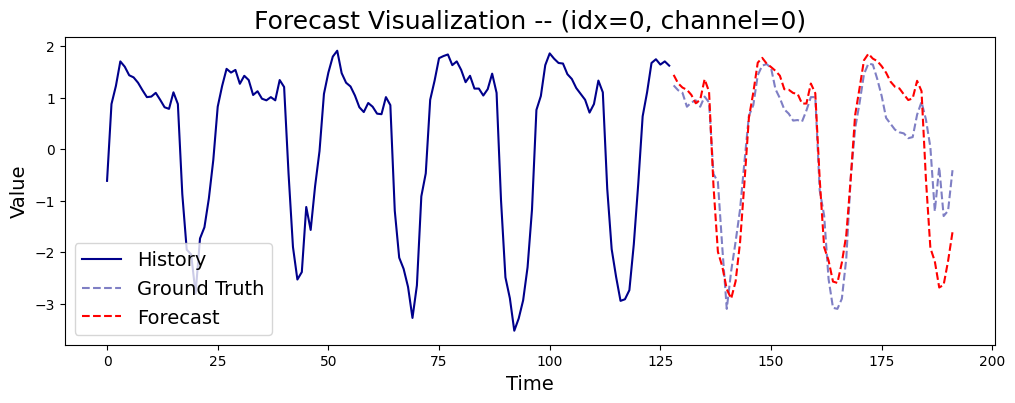

In [11]:
visualization = ForecastVisualization(trues, preds, histories)
visualization.plot(channel_idx=0, time_index=0)

In [13]:
data = test_dataset.dataset
data = np.array(data).transpose()

print(data.shape)

(7, 1408)


In [14]:
input = [torch.tensor(ts[:1000]) for i, ts in enumerate(data)]
print(input[0].shape)
predictions = ch.model.predict(context=input, prediction_length=64, num_samples=10)

torch.Size([1000])


In [8]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

In [ ]:
dataset = test_dataset.dataset
dataset = PandasDataset(dict(dataset))
train, test_template = split(dataset, offset=-128 + 20 * 64)
print(test_template)
print(len(dataset))
test_data = test_template.generate_instances(
    prediction_length=64, windows=20, distance=64
)

TestTemplate(dataset=PandasDataset<size=7, freq=h, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=OffsetSplitter(offset=1152))
7


In [19]:
print(test_data)

TestData(dataset=PandasDataset<size=7, freq=h, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=OffsetSplitter(offset=1152), prediction_length=64, windows=20, distance=64, max_history=None)


In [23]:
input_it = iter(test_data.input)
label_it = iter(test_data.label)
# inp = next(input_it)
# label = next(label_it)
print(inp)
print(label["target"].shape)

{'start': Period('2018-04-29 04:00', 'h'), 'target': array([15.3380003 , 15.00399971, 15.3380003 , ..., 14.33399963,
       15.67300034, 14.66899967]), 'item_id': 'HUFL'}
(64,)


In [ ]:
for inp, label in zip(input_it, label_it):
    print(inp["item_id"], label["item_id"], label["target"].shape)

HUFL HUFL (64,)
HUFL HUFL (64,)
HUFL HUFL (64,)
HUFL HUFL (64,)


AssertionError: Not enough data to generate some of the windows; try splitting data at an earlier offset

In [25]:
print(test_dataset.dataset)

                       HUFL   HULL    MUFL   MULL   LUFL   LULL      OT
date                                                                   
2018-04-29 04:00:00  15.338  2.478  10.661  0.604  4.508  1.188  11.748
2018-04-29 05:00:00  15.004  2.545  10.518  0.604  4.630  1.157  11.607
2018-04-29 06:00:00  15.338  1.741  10.127 -0.142  5.391  1.340  11.326
2018-04-29 07:00:00  10.449  1.541   5.082 -0.355  5.300  1.492  11.959
2018-04-29 08:00:00   3.751  1.741  -1.315 -0.036  5.056  1.492  12.592
...                     ...    ...     ...    ...    ...    ...     ...
2018-06-26 15:00:00  -1.674  3.550  -5.615  2.132  3.472  1.523  10.904
2018-06-26 16:00:00  -5.492  4.287  -9.132  2.274  3.533  1.675  11.044
2018-06-26 17:00:00   2.813  3.818  -0.817  2.097  3.716  1.523  10.271
2018-06-26 18:00:00   9.243  3.818   5.472  2.097  3.655  1.432   9.778
2018-06-26 19:00:00  10.114  3.550   6.183  1.564  3.716  1.462   9.567

[1408 rows x 7 columns]


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset


class ChronosWindowDataset(Dataset):
    """
    A PyTorch Dataset for sliding window extraction from time series data.
    """

    def __init__(self, data, context_len, horizon_len, stride=-1):
        """
        Initialize the dataset with sliding window logic.

        Args:
            data (pd.DataFrame): The input time series data.
            context_len (int): Length of the context window.
            horizon_len (int): Length of the forecast horizon.
            stride (int): Step size for sliding the window.
        """
        self.data = data
        self.context_len = context_len
        self.horizon_len = horizon_len
        self.total_len = context_len + horizon_len
        self.stride = stride

        if self.stride == -1:
            self.stride = self.horizon_len

        # Generate start indices for sliding windows
        self.indices = [
            start for start in range(0, len(data) - self.total_len + 1, self.stride)
        ]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start = self.indices[idx]
        window = self.data.iloc[start : start + self.total_len]

        # Extract context and actuals, and convert to Torch tensors
        context = torch.tensor(
            window.iloc[: self.context_len].to_numpy().transpose(), dtype=torch.float32
        )
        actual = torch.tensor(
            window.iloc[self.context_len :].to_numpy().transpose(), dtype=torch.float32
        )

        # # Return the input as a list of tensors (one for each column)
        # input_list = [context[i] for i in range(context.shape[0])]

        return context, actual

In [6]:
test_data = test_dataset.dataset
print(test_data)

In [ ]:
import torch
from torch.utils.data import Dataset

#  window_dataset = ChronosWindowDataset(data=test_data, context_len=128, horizon_len=64)
data_loader = DataLoader(test_data, batch_size=8, shuffle=False)

In [8]:
with torch.no_grad():
    for i, (context, actual) in enumerate(data_loader):
        print(context.shape)
        print(actual.shape)

torch.Size([8, 7, 128])
torch.Size([8, 7, 64])
torch.Size([8, 7, 128])
torch.Size([8, 7, 64])
torch.Size([8, 7, 128])
torch.Size([8, 7, 64])
torch.Size([8, 7, 128])
torch.Size([8, 7, 64])
torch.Size([8, 7, 128])
torch.Size([8, 7, 64])
torch.Size([8, 7, 128])
torch.Size([8, 7, 64])
torch.Size([4, 7, 128])
torch.Size([4, 7, 64])


In [9]:
input, actual = next(iter(data_loader))
input = input.squeeze()
actual = actual.squeeze()
print(input.shape)
print(actual.shape)

torch.Size([8, 7, 128])
torch.Size([8, 7, 64])


In [10]:
input_stack = input.reshape(-1, 128)
print(input_stack.shape)

torch.Size([56, 128])


In [11]:
actual = actual.reshape(-1, 64)
print(actual.shape)

torch.Size([56, 64])


In [ ]:
predictions = ch.model.predict(
    context=input_stack, prediction_length=64, num_samples=20
)

In [13]:
print(predictions.shape)

torch.Size([56, 20, 64])


In [ ]:
print(predictions.shape)
pred_median = np.median(predictions, axis=1)
print(pred_median.shape)
pred_quantiles = np.quantile(
    predictions, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], axis=1
)
print(pred_quantiles.shape)

torch.Size([56, 20, 64])
(56, 64)
(9, 56, 64)


In [48]:
actual = actual.reshape(-1, 64)
print(actual.shape)

torch.Size([56, 64])


In [15]:
mse1 = np.mean((actual.numpy() - pred_quantiles[4]) ** 2)
print(mse1)
mse1 = np.mean((actual.numpy() - pred_median) ** 2)
print(mse1)

13.570203633822203
13.570204


In [53]:
print(ch.model.model.device)

cpu


In [22]:
actual = actual.reshape(8, 7, 64)
pred_median = pred_median.reshape(8, 7, 64)
print(actual.shape)

(8, 7, 64)


In [18]:
mse1 = np.mean((actual - pred_median) ** 2)
print(mse1)

13.570204


In [13]:
data = test_dataset.dataset
print(len(data.iloc[:10]))

AttributeError: 'TimeSeriesDataset' object has no attribute 'iloc'